In [10]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [12]:
# Directories
data_dir = Path("../data/processed")
batch_size = 32
img_size = 224

# Data transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

# Load datasets
train_ds = datasets.ImageFolder(data_dir / "train", transform=transform)
val_ds = datasets.ImageFolder(data_dir / "val", transform=transform)
test_ds = datasets.ImageFolder(data_dir / "test", transform=transform)

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

class_names = train_ds.classes
print("Classes:", class_names)


Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Early_blight', 'Tomato_healthy']


In [13]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)


C:\Users\HomePC\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\HomePC/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:21<00:00, 2.14MB/s]


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)


In [17]:
def train_model(model, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}")

train_model(model)


Epoch 1/5, Loss: 1.4166
Epoch 2/5, Loss: 0.8131
Epoch 3/5, Loss: 0.5419
Epoch 4/5, Loss: 0.4050
Epoch 5/5, Loss: 0.3164


In [18]:
torch.save(model.state_dict(), "../model/plant_cnn.pt")


In [19]:
def evaluate(model, loader):
    model.eval()
    correct = total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")

evaluate(model, test_loader)


Accuracy: 97.22%


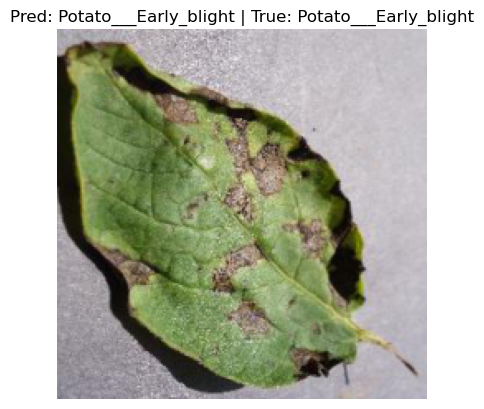

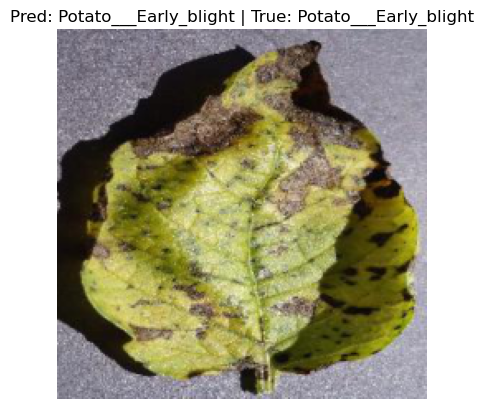

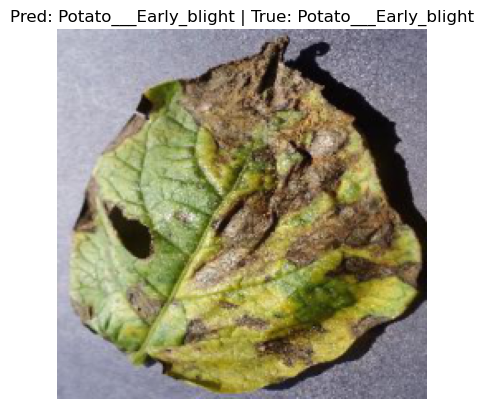

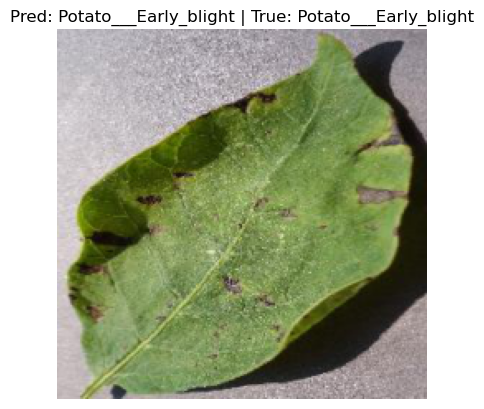

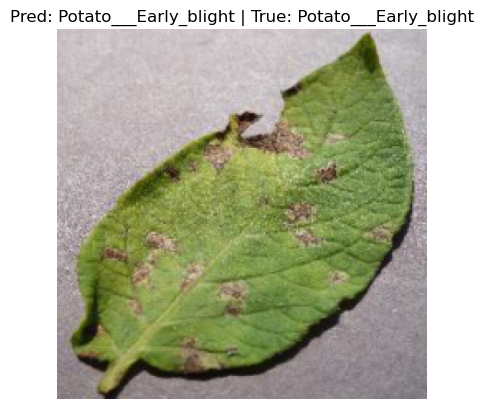

In [20]:
def show_preds(model, loader, n=5):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images[:n], labels[:n]
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[preds[i]]} | True: {class_names[labels[i]]}")
        plt.axis("off")
        plt.show()

show_preds(model, test_loader)
